In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, sklearn.preprocessing
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM

In [3]:
fpath = r"C:\Users\Downloads\DL\DL\DOM_hourly.csv"
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
print("Missing values:\n", df.isna().sum())

Missing values:
 DOM_MW    0
dtype: int64


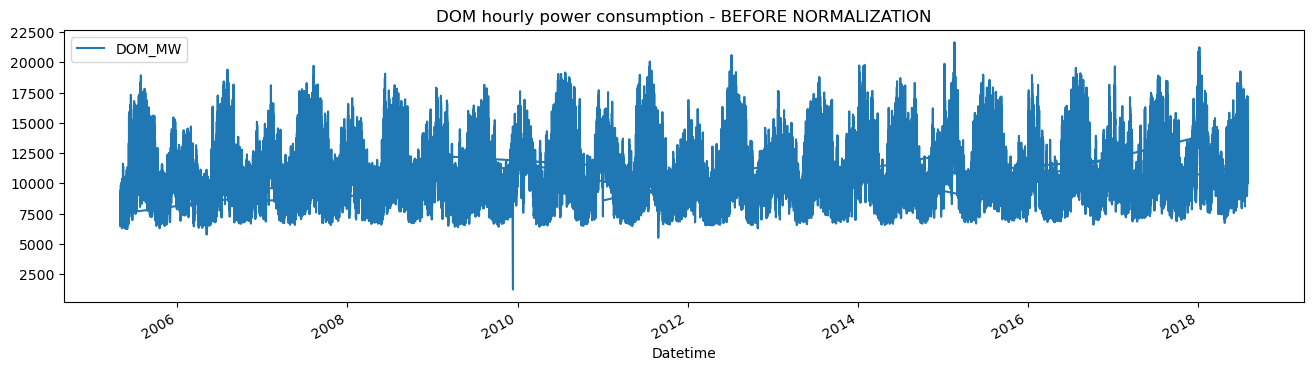

In [5]:
df.plot(figsize=(16,4), legend=True, title='DOM hourly power consumption - BEFORE NORMALIZATION')
plt.show()

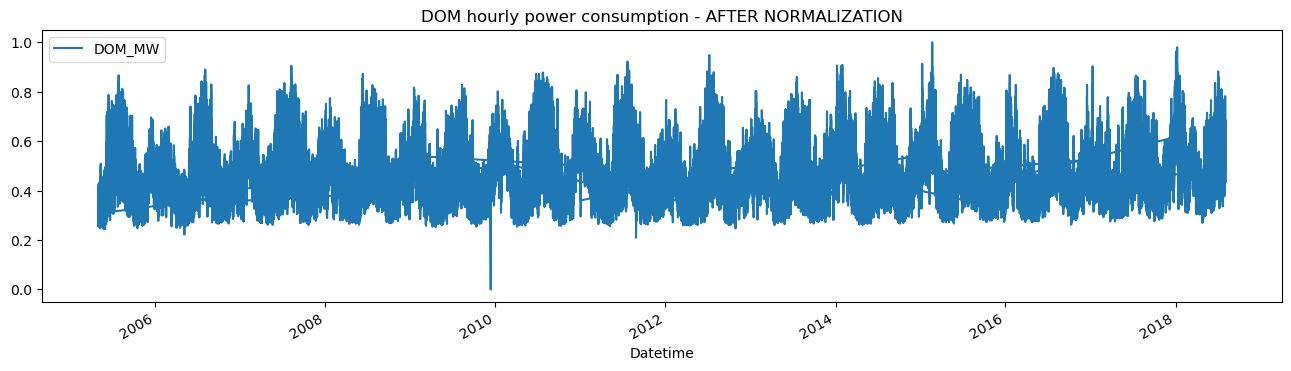

In [7]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['DOM_MW'] = scaler.fit_transform(df[['DOM_MW']])
df.plot(figsize=(16,4), legend=True, title='DOM hourly power consumption - AFTER NORMALIZATION')
plt.show()

In [9]:
def load_data(stock, seq_len=20):
    X, y = [], []
    for i in range(seq_len, len(stock)):
        X.append(stock.iloc[i-seq_len:i, 0])
        y.append(stock.iloc[i, 0])
    X, y = np.array(X), np.array(y)
    X_train, y_train = X[:110000], y[:110000]
    X_test, y_test = X[110000:], y[110000:]
    X_train = X_train.reshape((X_train.shape[0], seq_len, 1))
    X_test = X_test.reshape((X_test.shape[0], seq_len, 1))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(df)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (110000, 20, 1), Test: (6169, 20, 1)


C:\Users\kulla\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 0.1662
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0192
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0096
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0065
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0049
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
R² Score (Simple RNN): 0.9408838712852469


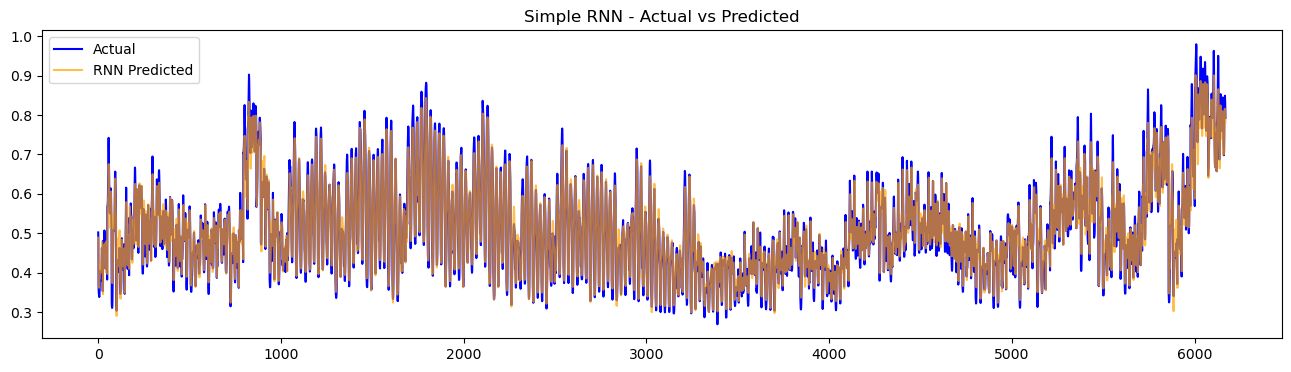

In [10]:
rnn_model = Sequential([
    SimpleRNN(40, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.15),
    SimpleRNN(40, activation='tanh', return_sequences=True),
    Dropout(0.15),
    SimpleRNN(40, activation='tanh'),
    Dropout(0.15),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='MSE')
rnn_model.fit(X_train, y_train, epochs=5, batch_size=1000, verbose=1)

rnn_pred = rnn_model.predict(X_test)
rnn_score = r2_score(y_test, rnn_pred)
print("R² Score (Simple RNN):", rnn_score)

plt.figure(figsize=(16,4))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(rnn_pred, label='RNN Predicted', color='orange', alpha=0.7)
plt.title("Simple RNN - Actual vs Predicted")
plt.legend(); plt.show()

C:\Users\kulla\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 289ms/step - loss: 0.0500
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
R² Score (LSTM): 0.28424827331687796


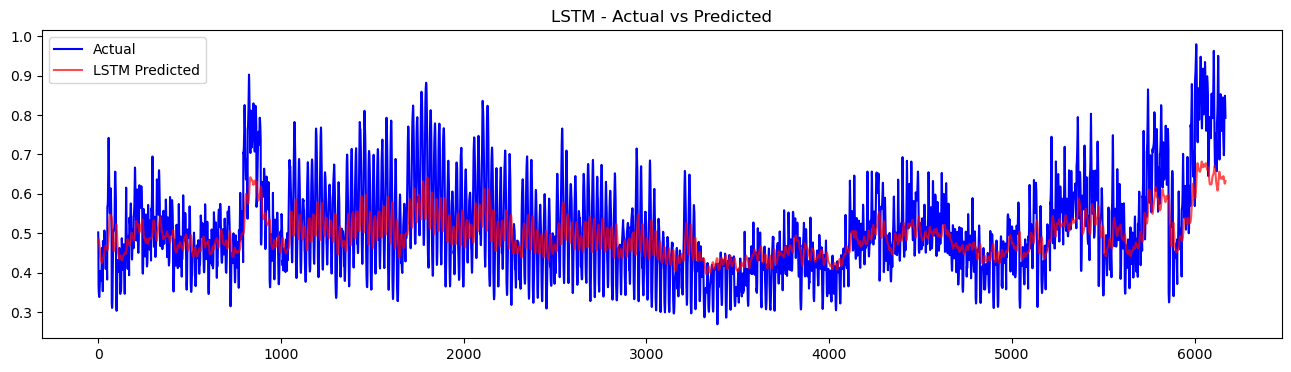

In [13]:
lstm_model = Sequential([
    LSTM(40, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.15),
    LSTM(40, activation='tanh', return_sequences=True),
    Dropout(0.15),
    LSTM(40, activation='tanh'),
    Dropout(0.15),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='MSE')
lstm_model.fit(X_train, y_train, epochs=1, batch_size=1000, verbose=1)

lstm_pred = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_pred)
print("R² Score (LSTM):", lstm_score)

# Plot LSTM predictions
plt.figure(figsize=(16,4))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(lstm_pred, label='LSTM Predicted', color='red', alpha=0.7)
plt.title("LSTM - Actual vs Predicted")
plt.legend(); plt.show()

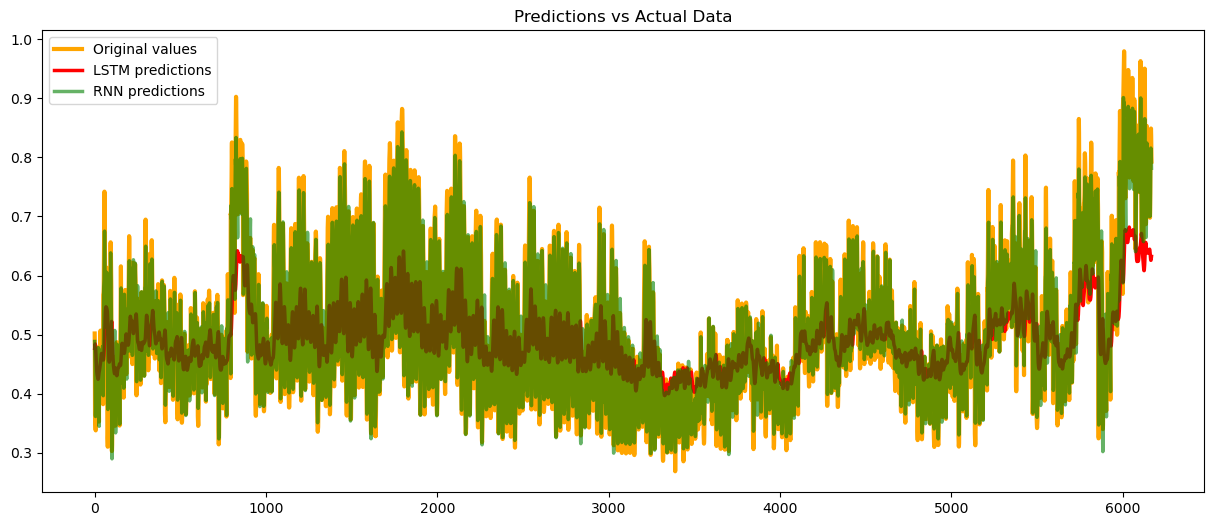

In [14]:
plt.figure(figsize=(15,6))
plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_pred, c="red", linewidth=2.5, label="LSTM predictions")
plt.plot(rnn_pred, alpha=0.6, c="green", linewidth=2.5, label="RNN predictions")
plt.title("Predictions vs Actual Data")
plt.legend()
plt.show()